In [ ]:
!pip install -q boto3

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
prefix_train = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_test)

s3_input_train_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_train_s3_uri, content_type='text/csv')
s3_input_validation_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_validation_s3_uri, content_type='text/csv')
s3_input_test_data = sagemaker.s3_input(s3_data=balanced_tfidf_without_header_test_s3_uri, content_type='text/csv')

print(s3_input_train_data.config)
print(s3_input_validation_data.config)
print(s3_input_test_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/data.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/data.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/data.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'text/csv'}


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri 

# get the URI for new container
builtin_container_uri = get_image_uri(region_name=region,                                
                                      repo_name='xgboost', 
                                      repo_version='0.90-2')
print(builtin_container_uri)

model_output_path = 's3://{}/models/built-in/training-runs'.format(bucket)
print(model_output_path)

xgb_estimator = sagemaker.estimator.Estimator(image_name=builtin_container_uri, 
                                              role=role, 
                                              train_instance_count=1, 
                                              train_instance_type='ml.m4.xlarge', 
                                              output_path=model_output_path, 
                                              sagemaker_session=sess)

xgb_estimator.set_hyperparameters(objective='binary:logistic',
                                  num_round=1,
                                  max_depth=5,
                                  eval_metric='auc')


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3
s3://sagemaker-us-east-1-835319576252/models/built-in/training-runs


In [4]:
xgb_estimator.fit({'train': s3_input_train_data,
                   'validation': s3_input_validation_data
                  }
                  #, wait=False
                 )

2020-03-05 06:33:46 Starting - Starting the training job...
2020-03-05 06:33:47 Starting - Launching requested ML instances.........
2020-03-05 06:35:23 Starting - Preparing the instances for training...
2020-03-05 06:36:16 Downloading - Downloading input data......
2020-03-05 06:37:05 Training - Downloading the training image..
2020-03-05 06:37:38 Uploading - Uploading generated training model
2020-03-05 06:37:38 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Deter

In [5]:
training_job_name = xgb_estimator.latest_training_job.name
print('training_job_name:  {}'.format(training_job_name))

training_job_name:  sagemaker-xgboost-2020-03-05-06-33-46-310


In [6]:
# TODO:  This is broken
#from sagemaker.xgboost import XGBoost

#xgb_estimator = XGBoost.attach(training_job_name=training_job_name)

#  Calculate Test Metrics

## Load the Model

In [7]:
# download the model artifact from AWS S3
!aws s3 cp $model_output_path/$training_job_name/output/model.tar.gz ./models/built-in/

download: s3://sagemaker-us-east-1-835319576252/models/built-in/training-runs/sagemaker-xgboost-2020-03-05-06-33-46-310/output/model.tar.gz to models/built-in/model.tar.gz


In [8]:
import tarfile
import pickle as pkl

# TODO:  extract to ./model/built-in/

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('./models/built-in/model.tar.gz')
tar.extractall(path='./models/built-in/')
tar.close()

In [9]:
!ls -al ./models/built-in/

total 20
drwxrwxr-x 2 ec2-user ec2-user 4096 Mar  5 06:37 .
drwxrwxr-x 4 ec2-user ec2-user 4096 Mar  5 06:37 ..
-rw-rw-r-- 1 ec2-user ec2-user 2737 Mar  5 06:37 model.tar.gz
-rw-r--r-- 1 ec2-user ec2-user 6273 Mar  5 06:37 xgboost-model


In [10]:
model_restored = pkl.load(open('./models/built-in/xgboost-model', 'rb'))

## Load Test Dataset

In [11]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf-without-header/data.csv

prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_test, exist_ok=True)

balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_test)

In [12]:
!aws s3 cp $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/data.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/data.csv


In [13]:
def load_dataset(path, sep, header):
    data = pd.read_csv(path, sep=sep, header=header)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [14]:
X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)


In [15]:
X_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.634733,-0.247392,0.069444,-0.523243,-0.004713,-0.448801,-0.204092,-0.238300,-0.261760,-0.219047,...,0.164698,-0.557045,-0.381416,-0.103129,-0.209871,-0.556612,1.304991,0.499820,1.384731,-0.083465
1,1.258064,-1.061612,-0.027788,-0.435960,0.519479,-0.291335,0.263390,-0.780300,-0.411519,-0.517505,...,-0.080147,0.484613,0.113549,-0.315451,0.965301,-2.017522,0.042569,-0.315694,-1.637476,1.099162
2,-0.123441,-0.381155,0.220870,-0.306529,0.295466,0.015603,0.808974,-0.886816,-0.537187,-1.609552,...,0.907523,-1.370449,-0.497941,-0.000245,-0.229369,-0.549921,-0.901384,0.611026,0.231871,-1.763118
3,-0.085429,-0.558576,-0.111424,-0.648954,-0.045818,-0.389012,-0.304378,-0.226467,0.129833,-0.374666,...,1.990565,0.674278,1.541115,-1.362709,-0.785404,2.047984,0.874032,-0.547825,-0.133409,0.407323
4,0.943603,-0.748338,-0.302065,-0.454148,-0.777959,-1.025572,-0.138429,0.392192,-0.901120,0.385676,...,-0.930250,1.317045,-1.353617,0.330193,-0.600254,0.714468,-1.320635,-2.121154,-0.086226,-0.318210


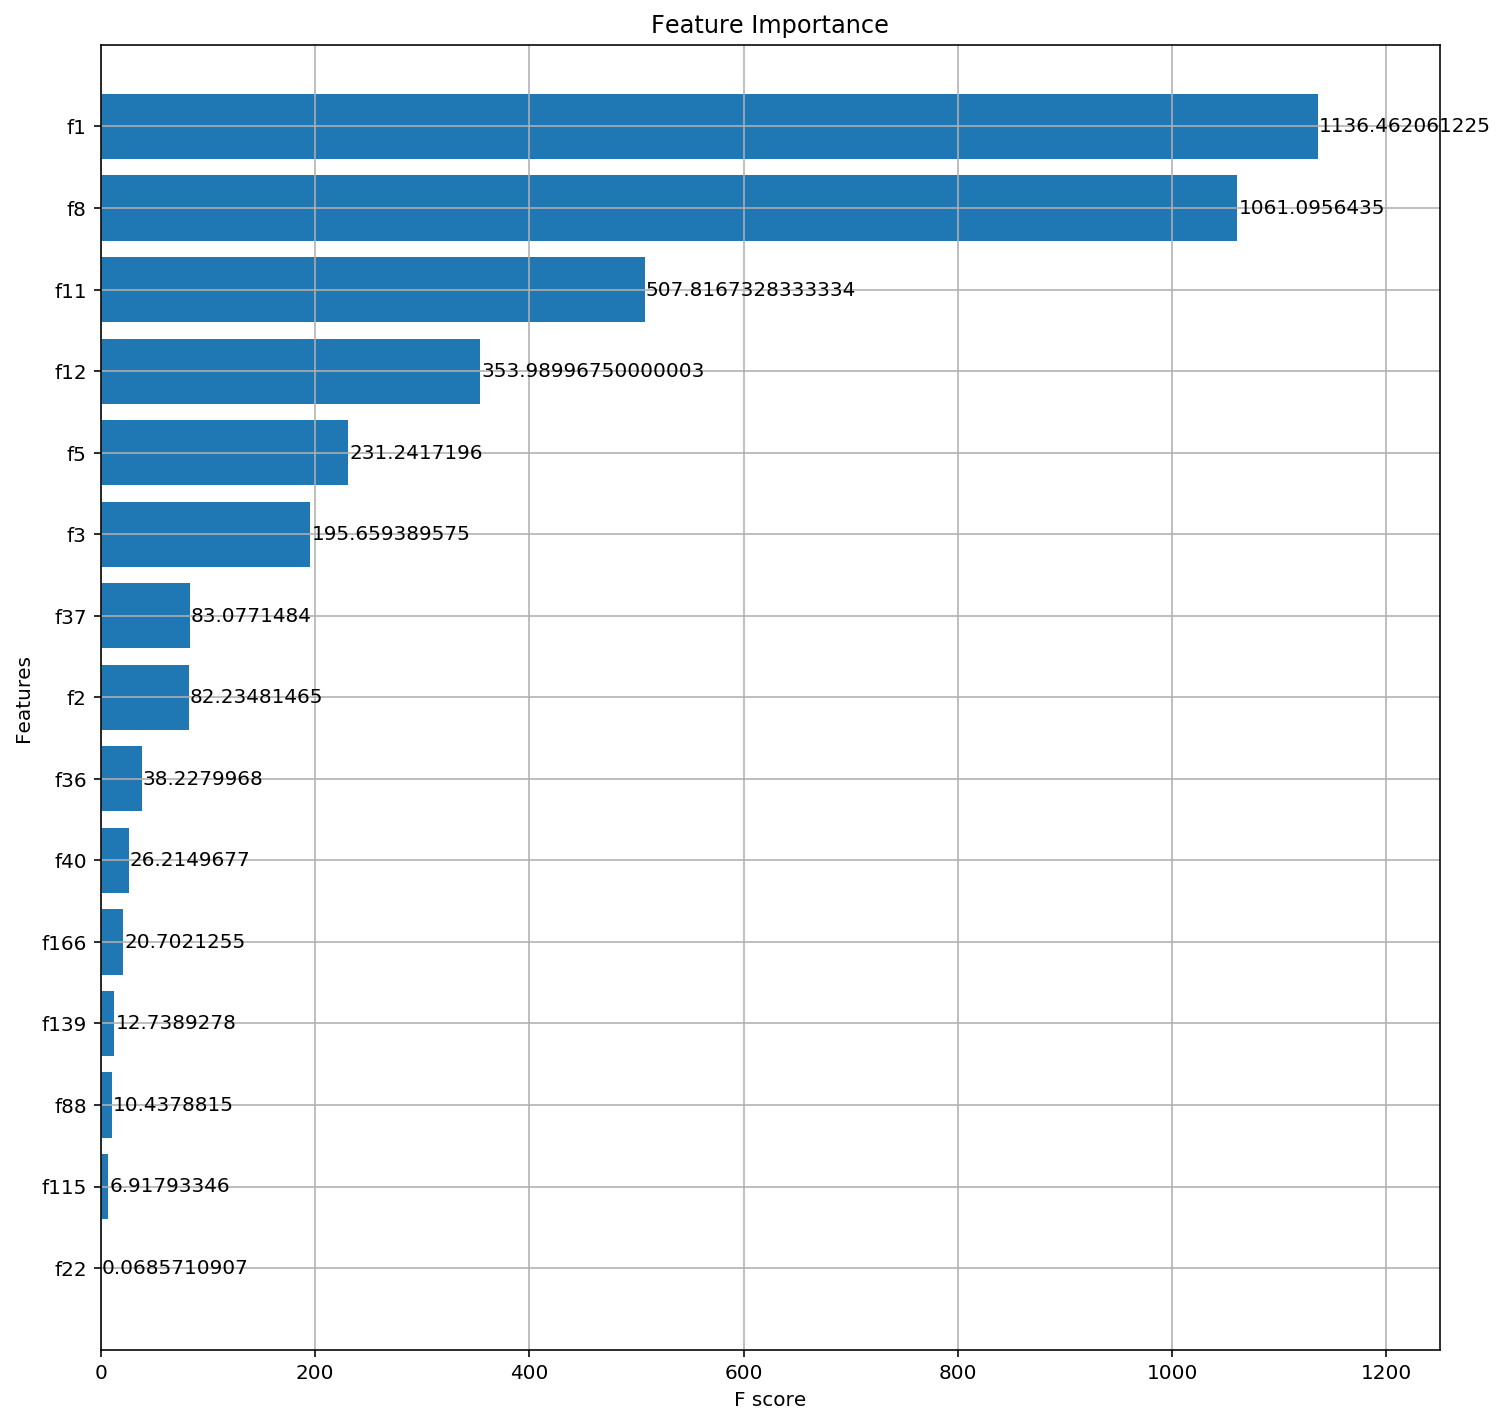

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

In [17]:
# Must convert pandas dataframe to XGBoost DMatrix before predicting
preds_test = model_restored.predict(xgboost.DMatrix(X_test.values))
preds_test.shape

(1781,)

### Convert regression values into classification (0 or 1) using threshold 0.5

In [18]:
import numpy as np
preds_test_0_or_1 = np.where(preds_test > 0.5, 1, 0)
preds_test_0_or_1.shape

(1781,)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test_0_or_1))
print('Test Precision: ', precision_score(y_test, preds_test_0_or_1, average=None))

Test Accuracy:  0.664795058955643
Test Precision:  [0.66442953 0.66516347]


In [20]:
print(classification_report(y_test, preds_test_0_or_1))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       891
           1       0.67      0.66      0.66       890

   micro avg       0.66      0.66      0.66      1781
   macro avg       0.66      0.66      0.66      1781
weighted avg       0.66      0.66      0.66      1781



In [21]:
df_cm_test = confusion_matrix(y_test, preds_test_0_or_1)
df_cm_test

array([[594, 297],
       [300, 590]])

[[594 297]
 [300 590]]


<Figure size 432x288 with 0 Axes>

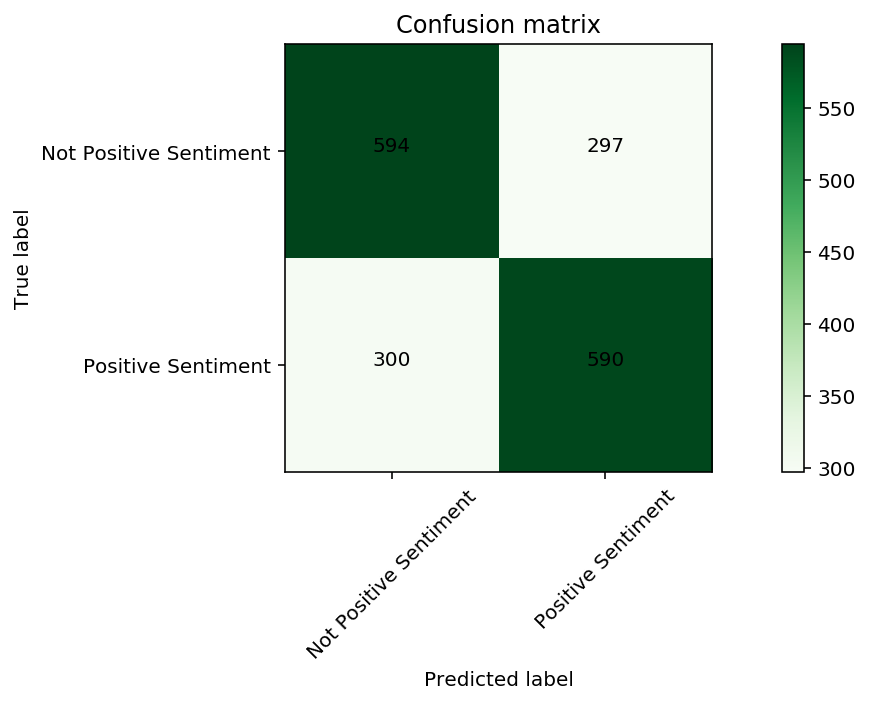

In [22]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

AUC is 0.6648


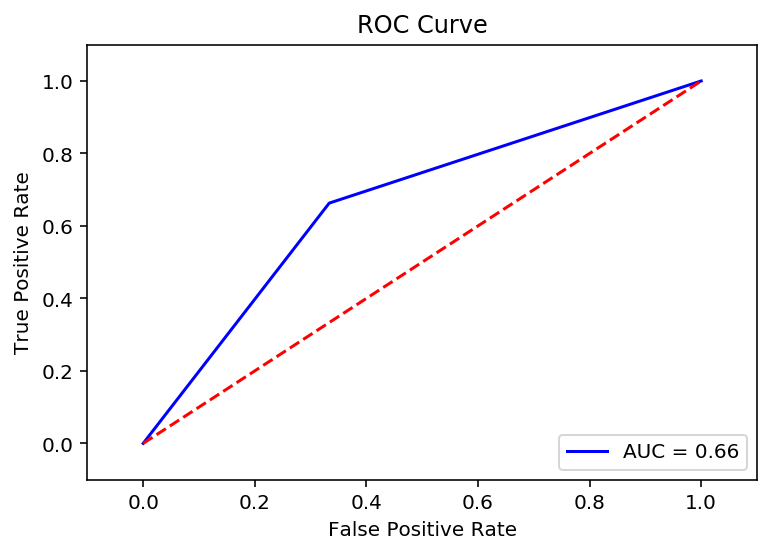

In [23]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Hyper Parameter Tuning

In [27]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:auc'

tuner_log = HyperparameterTuner(
    xgb_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=10,
    strategy='Bayesian'
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': balanced_tfidf_without_header_train_s3_uri, 
               'validation': balanced_tfidf_without_header_validation_s3_uri}, 
               include_cls_metadata=False)



'InProgress'

In [28]:
## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']


'Failed'

# Deploy Endpoint

### From an external application, you can use the following code to make a prediction

In [24]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [25]:
import time

# https://towardsdatascience.com/xgboost-in-amazon-sagemaker-28e5e354dbcd
from sagemaker.predictor import csv_serializer

xgb_endpoint_name = 'xgboost-built-in-{}'.format(time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()))
xgb_endpoint_name

'xgboost-built-in-2020-03-05-06-38-02'

In [26]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb_estimator.deploy(initial_instance_count = 1, 
                                     instance_type = 'ml.m4.xlarge',
                                     endpoint_name=xgb_endpoint_name)

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

--------

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

sm_runtime = boto3.client('sagemaker-runtime')

payload_500_samples = X_test[:500].to_csv(index=False, header=False).rstrip()

response_500_samples = sm_runtime.invoke_endpoint(
    EndpointName=xgb_endpoint_name,
    Body=payload.encode('utf-8'),
    ContentType='text/csv')['Body'].read()

In [ ]:
predictions_500_samples = np.fromstring(response_500_samples, sep=',')
predictions_500_samples_0_or_1 = np.where(predictions_500_samples > 0.5, 1, 0)

In [ ]:
print('Test Accuracy: ', accuracy_score(y_test[:500], predictions_500_samples_0_or_1))
print('Test Precision: ', precision_score(y_test[:500], predictions_500_samples_0_or_1, average=None))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test[:500], predictions_500_samples_0_or_1)
df_cm_test

In [ ]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# TODO:  XGBoostPredictor

In [ ]:
# TODO:  1) update this to do TF/IDF
#        2) use this in other versions of the model
# Derived from the following:
#   https://aim357.readthedocs.io/en/latest/GluePySparkMLFeatureEngineering/GluePySparkMLFeatureEngineering.html#deepar-deep-dive

class XGBoostPredictor(sagemaker.predictor.RealTimePredictor):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)

    def predict(self, ts, cat=None, dynamic_feat=None,
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }

        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }

        return json.dumps(http_request_data).encode('utf-8')

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq

def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

In [ ]:
xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

xgb_predictor = xgb_estimator.deploy(
                     initial_instance_count=1, 
                     instance_type='ml.m4.xlarge',
                     predictor_cls=XGBoostPredictor,
                     endpoint_name=xgb_endpoint_name)

In [ ]:
predictions, raw_outputs = model.predict(["""Very funny. A typical mid 50's comedy."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))

In [ ]:
predictions, raw_outputs = bert_model.predict(["""That movie was absolutely awful."""])
print('Predictions: {}'.format(predictions))
print('Raw outputs: {}'.format(raw_outputs))